In [1]:
import numpy as np
import ROOT as r
import sys,math,array,os
import matplotlib.pyplot as plt
r.gROOT.Macro(os.path.expanduser('~/.rootlogon_nystyle.C'))

Welcome to JupyROOT 6.12/07


0L

# load bunch of numpy arrays

In [2]:
sigaeloss_bb  = np.load('../data/sigaeloss_bb2.npy')
sigaeloss_bkg = np.load('../data/sigaeloss_bkg.npy')
mass_bb       = np.load('../data/mass_bb2.npy')
mass_bkg      = np.load('../data/mass_bkg.npy')
bkgaeloss_bb  = np.load('../data/bkgaeloss_bb2.npy')
bkgaeloss_bkg = np.load('../data/bkgaeloss_bkg.npy')

In [3]:
############### DEFAULT CUT BB1 ##############
sigae_wp = .65
bkgae_wp = 2

In [28]:
############### Alternate CUT BB1 ##############
sigae_wp = .6
bkgae_wp = 1.5

In [3]:
############### DEFAULT CUT BB2 ##############
sigae_wp = .8
bkgae_wp = 1.8

In [60]:
############### Alternate CUT BB2 ##############
sigae_wp = .7
bkgae_wp = 1.6

In [5]:
############### DEFAULT CUT BB3 ##############
sigae_wp = .66
bkgae_wp = 1.7

In [5]:
index_bb = np.where((bkgaeloss_bb>bkgae_wp)&(sigaeloss_bb<sigae_wp))[0]
index_bkg = np.where((bkgaeloss_bkg>bkgae_wp)&(sigaeloss_bkg<sigae_wp))[0]

print(index_bb.shape[0])
print(index_bkg.shape[0])

5017
4880


In [6]:
bins = np.linspace(1000,8000,71,dtype=np.int16)
print(bins)

[1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300
 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700
 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100
 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500
 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900
 8000]


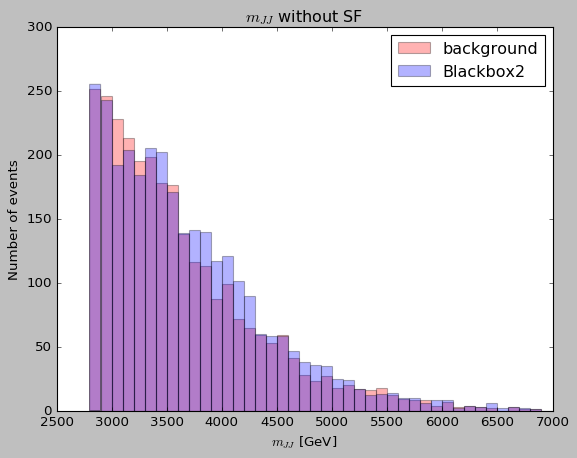

In [7]:
#### Without Scalefactor
#PLOT FOR BLACK BOX 1 with REALNVP
plt.style.use('default')
bins = np.linspace(2800,7000,43)
bkg_hist = plt.hist(mass_bkg[index_bkg],bins=bins,alpha=0.3,color='r',label='background');
obs_hist = plt.hist(mass_bb[index_bb],bins=bins,alpha=0.3,color='b',label='Blackbox2');
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.title('$m_{JJ}$ without SF')
plt.savefig("blackbox2.png")
plt.show()
#plt.axvline(x=38238
#plt.savefig("/data/t3home000/spark/LHCOlympics/plots/NEW_BB3_mjj_massratios_noscalefactor_1dot8_0dot5.png")

In [12]:
bins

array([2800., 2900., 3000., 3100., 3200., 3300., 3400., 3500., 3600.,
       3700., 3800., 3900., 4000., 4100., 4200., 4300., 4400., 4500.,
       4600., 4700., 4800., 4900., 5000., 5100., 5200., 5300., 5400.,
       5500., 5600., 5700., 5800., 5900., 6000., 6100., 6200., 6300.,
       6400., 6500., 6600., 6700., 6800., 6900., 7000.])

In [13]:
obs = obs_hist[0]

In [14]:
with open('blackbox2_hist.txt', 'w') as f_in:
    for i in range(len(obs)):
        f_in.write('bin_{} '.format(i))
        f_in.write('{} {}\n'.format(bins[i],obs[i]))

# Start Generating Shapes for the Fit

In [15]:
def smear(iVar,iDataHist,iScale=0.1):
    lDM     = r.RooRealVar("Xshift","Xshift", 1.,0.,200.)
    lVar    = iDataHist.createHistogram("x").GetMean()
    lInt    = iDataHist.createHistogram("x").Integral()
    lShift  = r.RooFormulaVar("Xsmear","("+iVar.GetName()+"-"+str(lVar)+")/Xshift+"+str(lVar),r.RooArgList(iVar,lDM))  
    lHPdf   = r.RooHistPdf(iDataHist.GetName()+"S",iDataHist.GetName()+"S", r.RooArgList(lShift),r.RooArgList(iVar),iDataHist,0)
    lDM.setVal(1.+iScale)
    lHUp = lHPdf.createHistogram("x")
    lHUp.Scale(lInt)
    lUp = r.RooDataHist(iDataHist.GetName()+"_smearUp",iDataHist.GetName()+"_smearUp", r.RooArgList(iVar),lHUp)    
    lDM.setVal(1.-iScale)
    lHDown = lHPdf.createHistogram("x")
    lHDown.Scale(lInt)
    lDown  = r.RooDataHist(iDataHist.GetName()+"_smearDown",iDataHist.GetName()+"_smearDown", r.RooArgList(iVar),lHDown)
    return [lUp,lDown] 

In [16]:
xlow, xhigh = 2800,7000
bins = (xhigh-xlow)/100

In [17]:
# Observable
x = r.RooRealVar("x","m_{JJ} [GeV]", xlow, xhigh)

In [18]:
roothist_obs = r.TH1F('data_obs','data_obs',bins,xlow,xhigh)
roothist_bkg = r.TH1F('purebkg','purebkg',bins,xlow,xhigh)

In [19]:
for i in range(0,bins):
    roothist_obs.SetBinContent(i+1,obs_hist[0][i])
    roothist_bkg.SetBinContent(i+1,bkg_hist[0][i])

In [20]:
bins

42

In [21]:
roothist_sig

NameError: name 'roothist_sig' is not defined

In [23]:
mygaus = r.TF1("mygaus","TMath::Gaus(x,4100,300)",xlow, xhigh)
smear_up = r.TF1("smear_up","TMath::Gaus(x,4100,80)",xlow, xhigh)
smear_down = r.TF1("smear_down","TMath::Gaus(x,4100,600)",xlow, xhigh)
scale_up = r.TF1("scale_up","TMath::Gaus(x,4700,300)",xlow, xhigh)
scale_down = r.TF1("scale_down","TMath::Gaus(x,3500,300)",xlow, xhigh)


roothist_sig = r.TH1F('signal','signal',bins,xlow, xhigh)
roothist_scup = r.TH1F('signal_scaleUp','signal',bins,xlow, xhigh)
roothist_scdown = r.TH1F('signal_scaleDown','signal',bins,xlow, xhigh)
roothist_smup = r.TH1F('signal_smearUp','signal',bins,xlow, xhigh)
roothist_smdown = r.TH1F('signal_smearDown','signal',bins,xlow, xhigh)

roothist_sig.FillRandom("mygaus",1000)
roothist_scup.FillRandom('scale_up',1000)

roothist_scdown.FillRandom('scale_down',1000)
roothist_smup.FillRandom('smear_up',1000)
roothist_smdown.FillRandom('smear_down',1000)


Warning in <TROOT::Append>: Replacing existing TH1: signal (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: signal_scaleUp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: signal_scaleDown (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: signal_smearUp (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: signal_smearDown (Potential memory leak).


In [24]:
iDataHist = r.RooDataHist("signal","signal",r.RooArgList(x),roothist_sig)

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(signal): fit range of variable x expanded to nearest bin boundaries: [2800,7000] --> [2800,7000]


In [25]:
f = r.TFile.Open("shapes-blackbox2-TH1.root",'recreate')
roothist_sig.Write()
roothist_obs.Write()
roothist_bkg.Write()
roothist_scup.Write()
roothist_scdown.Write()
roothist_smup.Write()
roothist_smdown.Write()

f.Close()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: myCanvasName


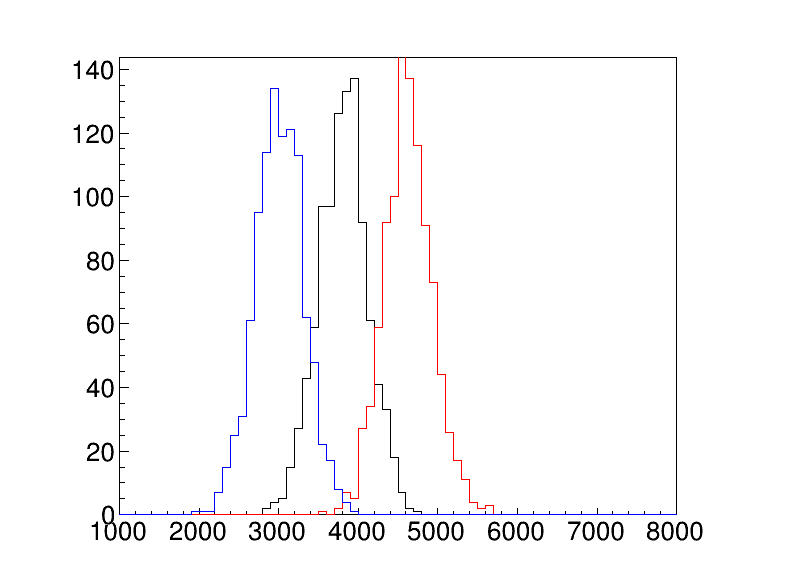

In [89]:
c11 = r.TCanvas("myCanvasName","The Canvas Title",800,600)
roothist_sig.Draw()
roothist_scup.SetLineColor(r.kRed)
roothist_scup.Draw('same')

roothist_scdown.SetLineColor(r.kBlue)
roothist_scdown.Draw('same')
c11.Draw()

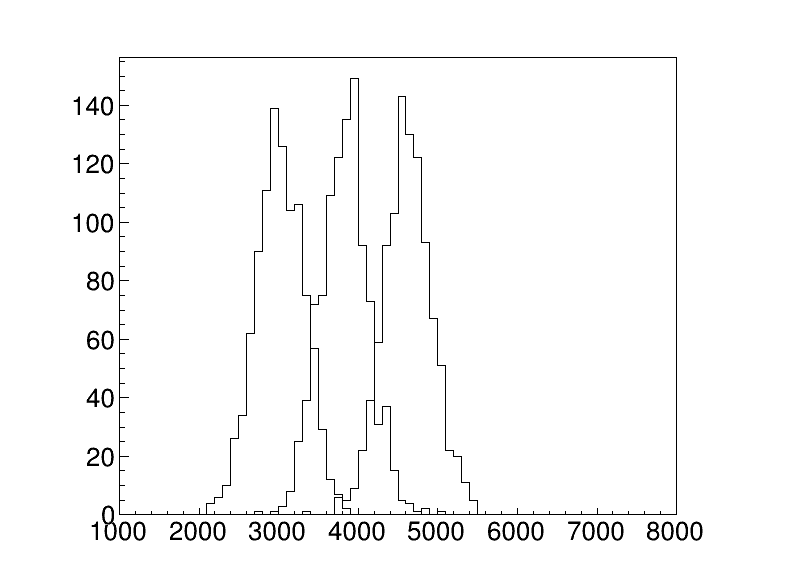

In [11]:
c11 = r.TCanvas("myCanvasName","The Canvas Title",800,600)
roothist_sig.Draw()
roothist_scup.Draw('same')
roothist_scdown.Draw('same')
c11.Draw()

In [64]:
f = r.TFile.Open("shapes-blackbox1-TH1.root",'read')
f.ls()
f.Close()

TFile**		shapes-blackbox1-TH1.root	
 TFile*		shapes-blackbox1-TH1.root	
  KEY: TH1F	signal;1	signal
  KEY: TH1F	data_obs;1	data_obs
  KEY: TH1F	purebkg;1	purebkg
  KEY: TH1F	signal_scaleUp;1	signal
  KEY: TH1F	signal_scaleDown;1	signal
  KEY: TH1F	signal_smearUp;1	signal
  KEY: TH1F	signal_smearDown;1	signal


In [86]:
ObsHist = r.RooDataHist("data_obs","data_obs",r.RooArgList(x),roothist_obs)
BkgHist = r.RooDataHist("purebkg","purebkg",r.RooArgList(x),roothist_bkg)

NameError: name 'roothist_obs' is not defined

In [38]:
f = r.TFile.Open("shapes-blackbox1-TH1.root",'recreate')
ObsHist.Write()
BkgHist.Write()
iDataHist.Write()

f.Close()

In [28]:
iDataHist = r.RooDataHist("signal","signal",r.RooArgList(x),roothist_sig)

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(signal): fit range of variable x expanded to nearest bin boundaries: [1000,8000] --> [1000,8000]


In [11]:
smear_up, smear_down = smear(x,iDataHist,0.1)

[#1] INFO:InputArguments -- RooAbsReal::createHistogram(signalS) INFO: Model has intrinsic binning definition, selecting that binning for the histogram
[#1] INFO:NumericIntegration -- RooRealIntegral::init(signalS_Int[x]) using numeric integrator RooBinIntegrator to calculate Int(x)
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(signal_smearUp): fit range of variable x expanded to nearest bin boundaries: [1000,8000] --> [1000,8000]
[#1] INFO:InputArguments -- RooAbsReal::createHistogram(signalS) INFO: Model has intrinsic binning definition, selecting that binning for the histogram
[#1] INFO:NumericIntegration -- RooRealIntegral::init(signalS_Int[x]) using numeric integrator RooBinIntegrator to calculate Int(x)
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(signal_smearDown): fit range of variable x expanded to nearest bin boundaries: [1000,8000] --> [1000,8000]


Warning in <TROOT::Append>: Replacing existing TH1: signal__x (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: signalS__x (Potential memory leak).


In [12]:
def shift(iVar,iDataHist,iShift=5.):
    lInt    = iDataHist.createHistogram("x").Integral()
    lDM     = r.RooRealVar   ("Xdm","Xdm", 0.,-300,300)
    lShift  = r.RooFormulaVar("Xshift",iVar.GetName()+"-Xdm",r.RooArgList(iVar,lDM))
    print(lShift)
    lSPdf   = r.RooHistPdf(iDataHist.GetName()+"P",iDataHist.GetName()+"P", r.RooArgList(lShift),r.RooArgList(iVar),iDataHist,0)
    lDM.setVal(iShift)
    lHUp   = lSPdf.createHistogram("x")
    lHUp.Scale(lInt)
    lUp    = r.RooDataHist(iDataHist.GetName()+"_scaleUp",iDataHist.GetName()+"_scaleUp", r.RooArgList(iVar),lHUp)
    lDM.setVal(-iShift)
    lHDown = lSPdf.createHistogram("x")
    lHDown.Scale(lInt)
    lDown  = r.RooDataHist(iDataHist.GetName()+"_scaleDown",iDataHist.GetName()+"_scaleDown", r.RooArgList(iVar),lHDown)
    return (lUp,lDown)

In [13]:
shift_up, shift_down = shift(x,iDataHist,20.0)

<ROOT.RooFormulaVar object ("Xshift") at 0xb01e030>
[#1] INFO:InputArguments -- RooAbsReal::createHistogram(signalP) INFO: Model has intrinsic binning definition, selecting that binning for the histogram
[#1] INFO:NumericIntegration -- RooRealIntegral::init(signalP_Int[x]) using numeric integrator RooBinIntegrator to calculate Int(x)
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(signal_scaleUp): fit range of variable x expanded to nearest bin boundaries: [1000,8000] --> [1000,8000]
[#1] INFO:InputArguments -- RooAbsReal::createHistogram(signalP) INFO: Model has intrinsic binning definition, selecting that binning for the histogram
[#1] INFO:NumericIntegration -- RooRealIntegral::init(signalP_Int[x]) using numeric integrator RooBinIntegrator to calculate Int(x)
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(signal_scaleDown): fit range of variable x expanded to nearest bin boundaries: [1000,8000] --> [1000,8000]


Warning in <TROOT::Append>: Replacing existing TH1: signal__x (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: signalP__x (Potential memory leak).


In [22]:
xframe = x.frame()

In [50]:
a = smear_up.generateBinned("x",100)

AttributeError: 'RooDataHist' object has no attribute 'generateBinned'

In [ ]:
print(h_)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: myCanvasName


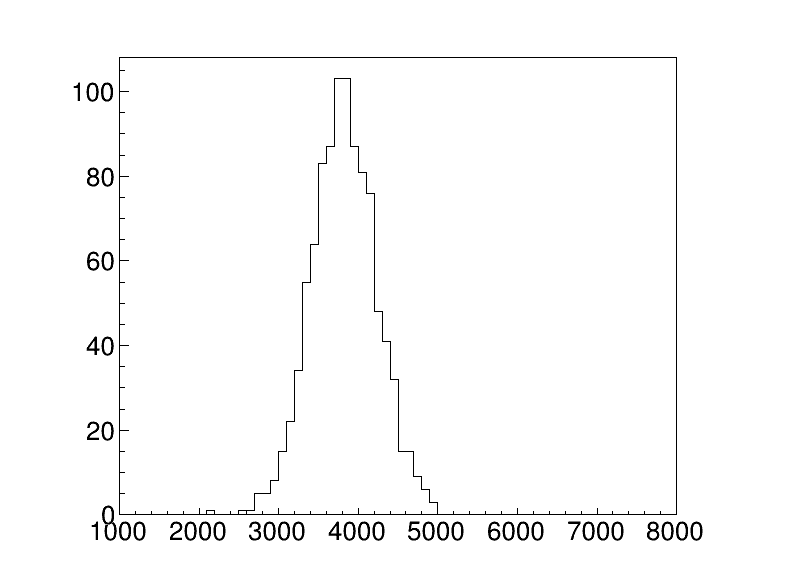

In [53]:
c11 = r.TCanvas("myCanvasName","The Canvas Title",800,600)
roothist_sig.Draw()
c11.Draw()

In [ ]:
#c.plotOn(xframe,r.RooFit.DrawOption("*"),r.RooFit.DataError(0))
smear_up.plotOn(xframe,r.RooFit.MarkerColor(9),r.RooFit.DataError(0))
iDataHist.plotOn(xframe,r.RooFit.MarkerColor(r.kBlack),r.RooFit.DataError(0))
smear_down.plotOn(xframe,r.RooFit.MarkerColor(8),r.RooFit.DataError(0))
c11 = r.TCanvas("myCanvasName","The Canvas Title",800,600)
#model.plotOn(mjjframe, r.RooFit.Components("background"), r.RooFit.LineStyle(r.kDashed))
xframe.Draw()

c11.Draw()

[#0] WARNING:Plotting -- RooHist::addBin(signal_smearUp_plot__x) WARNING: non-integer bin entry 0.921659 with Poisson errors, interpolating between Poisson errors of adjacent integer
[#0] WARNING:Plotting -- RooHist::addBin(signal_smearUp_plot__x) WARNING: non-integer bin entry 0.921659 with Poisson errors, interpolating between Poisson errors of adjacent integer
[#0] WARNING:Plotting -- RooHist::addBin(signal_smearUp_plot__x) WARNING: non-integer bin entry 0.921659 with Poisson errors, interpolating between Poisson errors of adjacent integer
[#0] WARNING:Plotting -- RooHist::addBin(signal_smearUp_plot__x) WARNING: non-integer bin entry 3.68664 with Poisson errors, interpolating between Poisson errors of adjacent integer
[#0] WARNING:Plotting -- RooHist::addBin(signal_smearUp_plot__x) WARNING: non-integer bin entry 7.37327 with Poisson errors, interpolating between Poisson errors of adjacent integer
[#0] WARNING:Plotting -- RooHist::addBin(signal_smearUp_plot__x) WARNING: non-integer b

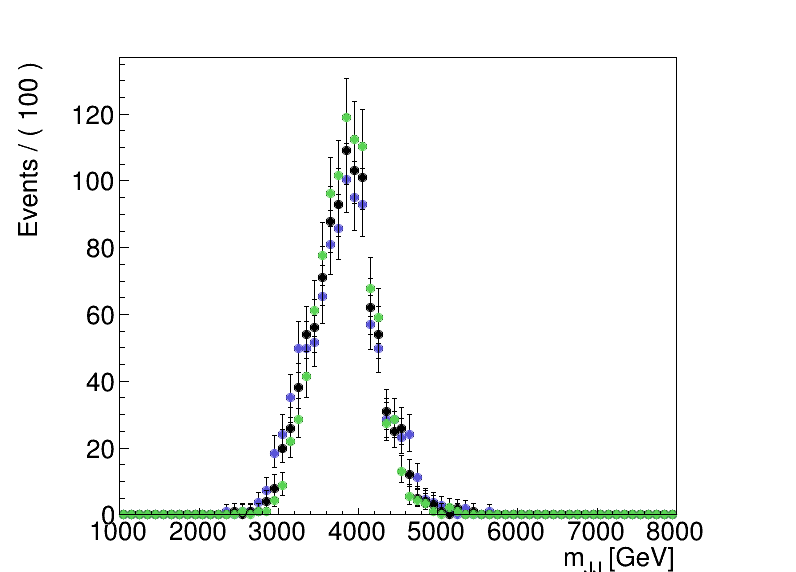

In [16]:
#c.plotOn(xframe,r.RooFit.DrawOption("*"),r.RooFit.DataError(0))
smear_up.plotOn(xframe,r.RooFit.MarkerColor(9),r.RooFit.DataError(0))
iDataHist.plotOn(xframe,r.RooFit.MarkerColor(r.kBlack),r.RooFit.DataError(0))
smear_down.plotOn(xframe,r.RooFit.MarkerColor(8),r.RooFit.DataError(0))
c11 = r.TCanvas("myCanvasName","The Canvas Title",800,600)
#model.plotOn(mjjframe, r.RooFit.Components("background"), r.RooFit.LineStyle(r.kDashed))
xframe.Draw()

c11.Draw()

In [89]:
roothist_obs = r.TH1F('data_obs','data_obs',bins,xlow,xhigh)
roothist_bkg = r.TH1F('purebkg','purebkg',bins,xlow,xhigh)

In [90]:
for i in range(0,bins):
    roothist_obs.SetBinContent(i+1,obs_hist[0][i])
    roothist_bkg.SetBinContent(i+1,bkg_hist[0][i])

In [19]:
ObsHist = r.RooDataHist("data_obs","data_obs",r.RooArgList(x),roothist_obs)
BkgHist = r.RooDataHist("purebkg","purebkg",r.RooArgList(x),roothist_bkg)

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(data_obs): fit range of variable x expanded to nearest bin boundaries: [1000,8000] --> [1000,8000]
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(purebkg): fit range of variable x expanded to nearest bin boundaries: [1000,8000] --> [1000,8000]


In [40]:
f = r.TFile.Open("shapes-blackbox1-TH1.root",'recreate')
roothist_sig.Write()
roothist_bkg.Write()
roothist_obs.Write()
smear_up.Write()
smear_down.Write()
shift_up.Write()
shift_down.Write()
f.Close()

In [21]:
f.Close()

In [42]:
f = r.TFile.Open("shapes-blackbox1-TH1.root",'read')

In [43]:
f.ls()

TFile**		shapes-blackbox1-TH1.root	
 TFile*		shapes-blackbox1-TH1.root	
  KEY: TH1F	signal;1	signal
  KEY: TH1F	purebkg;1	purebkg
  KEY: TH1F	data_obs;1	data_obs
  KEY: RooDataHist	signal_smearUp;1	signal_smearUp
  KEY: TProcessID	ProcessID0;1	71ce7dba-8bce-11ea-9205-51700412beef
  KEY: RooDataHist	signal_smearDown;1	signal_smearDown
  KEY: RooDataHist	signal_scaleUp;1	signal_scaleUp
  KEY: RooDataHist	signal_scaleDown;1	signal_scaleDown


In [44]:
f.Close()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: myCanvasName


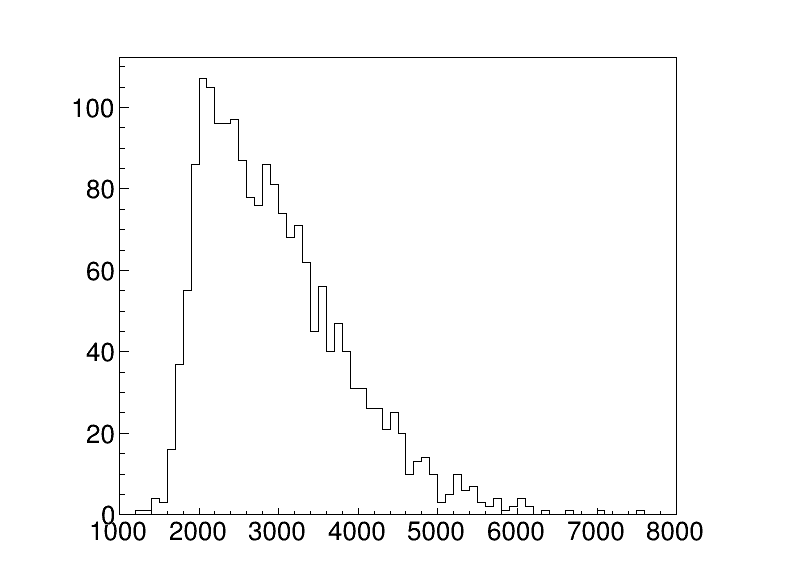

In [36]:
c = r.TCanvas("myCanvasName","The Canvas Title",800,600)
roothist_bkg.Draw()
c.Draw()

In [ ]:
function_gaus = r.TF1("mygaus","TMath::Gaus(x,3823,400)",1000,8000)
roothist_sig = r.TH1F('signal','signal',70,1000,8000)
roothist_sig.FillRandom("mygaus",10000)

In [ ]:
lDM   = rt.RooRealVar("Xshift","Xshift", 1.,0.,2.)
x     = rt.RooRealVar("x" ,"x", 0.0   ,1000  ,8000)
mean  = rt.RooRealVar("mean",'mean',3823,1000,8000)
sigma = rt.RooRealVar("sigma",'sigma',200,0,500)

In [ ]:
lDM     = rt.RooRealVar("Xshift","Xshift", 1.,0.,2.)
lVar    = iDataHist.createHistogram("x").GetMean()
lInt    = iDataHist.createHistogram("x").Integral()

In [ ]:
iVar = rt.RooRealVar("x","x",3600,1000,8000)
lShift  = rt.RooFormulaVar("Xsmear","("+iVar.GetName()+"-"+str(lVar)+")/Xshift+"+str(lVar),rt.RooArgList(iVar,lDM))  

In [ ]:
def smear(iVar,iDataHist,iScale=0.1):
    lDM     = rt.RooRealVar("Xshift","Xshift", 1.,0.,2.)
    lVar    = iDataHist.createHistogram("x").GetMean()
    lInt    = iDataHist.createHistogram("x").Integral()
    lShift  = r.RooFormulaVar("Xsmear","("+iVar.GetName()+"-"+str(lVar)+")/Xshift+"+str(lVar),r.RooArgList(iVar,lDM))  
    if f2D:
        lHPdf   = r.RooHistPdf(iDataHist.GetName()+"S",iDataHist.GetName()+"S", r.RooArgList(lShift,fVars[1]),r.RooArgList(iVar,fVars[1]),iDataHist,0)
    else:
        lHPdf   = r.RooHistPdf(iDataHist.GetName()+"S",iDataHist.GetName()+"S", r.RooArgList(lShift),r.RooArgList(iVar),iDataHist,0)
    lDM.setVal(1.+iScale)
    lHUp = lHPdf.createHistogram("x")
    lHUp.Scale(lInt)
    lUp = r.RooDataHist(iDataHist.GetName()+"_smearUp",iDataHist.GetName()+"_smearUp", r.RooArgList(iVar),lHUp)    
    lDM.setVal(1.-iScale)
    lHDown = lHPdf.createHistogram("x")
    lHDown.Scale(lInt)
    lDown  = r.RooDataHist(iDataHist.GetName()+"_smearDown",iDataHist.GetName()+"_smearDown", r.RooArgList(iVar),lHDown)
    return [lUp,lDown] 